### Import python packages

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from yahooquery import Ticker

import torch
import torch.utils.data
from torch import optim
from torch import nn
from torch.autograd import Variable

In [2]:
from ibov.utils import load_config
from ibov.feature import create_lags
from ibov.training import IbovModel, train

### Load Data

In [3]:
config = load_config()

In [4]:
data_root_dir = config["data"]["root"]

In [5]:
ibov = Ticker(symbols = config["ibovespa"]["ticker"])
ibov_data = ibov.history(period="max")
ibov_data.to_csv(f"{data_root_dir}/ibovespa.csv")

### Geração dos conjuntos de dados de treino

In [6]:
dados_ibov = pd.read_csv(f"{data_root_dir}/ibovespa.csv")

In [7]:
dados_ibov_train = dados_ibov.sort_values(by="date", ascending=False)[180:360].reset_index(drop="True")
dados_ibov_train.head()

,symbol,date,open,close,low,high,volume,adjclose
0,^BVSP,2020-04-08,76335.0,78625.0,76115.0,79058.0,10206300.0,78625.0
1,^BVSP,2020-04-07,74078.0,76358.0,74078.0,79855.0,11286500.0,76358.0
2,^BVSP,2020-04-06,69556.0,74073.0,69556.0,75260.0,9685400.0,74073.0
3,^BVSP,2020-04-03,72241.0,69538.0,67802.0,72241.0,10411300.0,69538.0
4,^BVSP,2020-04-02,70969.0,72253.0,70957.0,73861.0,10540200.0,72253.0


In [8]:
dados_ibov_valid = dados_ibov.sort_values(by="date", ascending=False)[0:180].reset_index(drop="True")
dados_ibov_valid.head()

,symbol,date,open,close,low,high,volume,adjclose
0,^BVSP,2020-12-30,119410.0,119306.0,118919.0,120150.0,8235700.0,119306.0
1,^BVSP,2020-12-29,119130.0,119475.0,118750.0,119861.0,6769700.0,119475.0
2,^BVSP,2020-12-28,117806.0,119051.0,117805.0,119213.0,7171700.0,119051.0
3,^BVSP,2020-12-23,116636.0,117857.0,116636.0,118311.0,6483300.0,117857.0
4,^BVSP,2020-12-22,115825.0,116348.0,115648.0,116903.0,6947900.0,116348.0


In [9]:
window = config["feature"]["window"]

In [10]:
trainY, trainX = create_lags(data = dados_ibov_train["close"], window = window)
validY, validX = create_lags(data = dados_ibov_valid["close"], window = window)

### Definição do modelo

#### Test Net

random_data = torch.rand((1, 1, 7))
test_net = Net(window=window)
result = test_net(random_data)
print(result)

### Train Net

In [11]:
torch.manual_seed(0)

In [12]:
tensor_x = torch.Tensor(np.array(trainX))
tensor_y = torch.Tensor(np.array(trainY))

In [13]:
tensor_val_x = torch.Tensor(np.array(validX))
tensor_val_y = torch.Tensor(np.array(validY))

In [14]:
dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10)

In [15]:
val_dataset = torch.utils.data.TensorDataset(tensor_val_x,tensor_val_y)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=10)

In [16]:
model = IbovModel(window=window)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

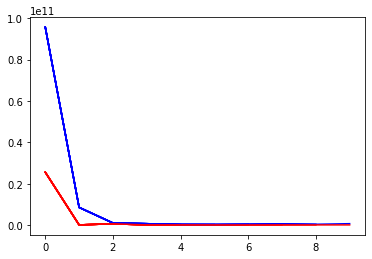

In [17]:
train(dataloader, val_dataloader, model, criterion, optimizer, epochs=10)

In [18]:
import seaborn as sns

In [19]:
prediction = np.hstack(model(tensor_x).detach().numpy()).tolist()
true_value = np.hstack(trainY).tolist()
evaluation_data = pd.DataFrame(columns=["pred", "true"])
evaluation_data["pred"] = prediction
evaluation_data["true"] = true_value
evaluation_data.head()

,pred,true
0,75069.867188,78625.0
1,71456.781250,76358.0
2,71192.031250,74073.0
3,71550.601562,69538.0
4,72231.890625,72253.0


In [20]:
prediction = np.hstack(model(tensor_val_x).detach().numpy()).tolist()
true_value = np.hstack(validY).tolist()
evaluation = pd.DataFrame(columns=["pred", "true"])
evaluation["pred"] = prediction
evaluation["true"] = true_value
evaluation.head()

,pred,true
0,119317.031250,119306.0
1,118438.812500,119475.0
2,117058.203125,119051.0
3,116241.851562,117857.0
4,117085.617188,116348.0


In [22]:
from sklearn.metrics import median_absolute_error, accuracy_score, confusion_matrix

In [23]:
median_absolute_error(evaluation.true, evaluation.pred)

1173.91015625

In [24]:
np.mean(np.abs(evaluation.true - evaluation.pred))

1322.4317064606741

evaluation = evaluation.append(evaluation_data)

In [ ]:
true = evaluation.true[:-1].reset_index(drop=True)
pred = evaluation.true[1:].reset_index(drop=True)

In [ ]:
a = pd.DataFrame(columns=["pred", "true"])
a["pred"] = pred
a["true"] = true

In [ ]:
pred

In [ ]:
delta_pred = [1 if np.sign(pred[idx]-pred[idx+1]) >=0 else 0 for idx in range(pred.shape[0]-1)]
delta_true = [1 if np.sign(true[idx]-true[idx+1]) >=0 else 0 for idx in range(true.shape[0]-1)]

In [ ]:
confusion_matrix(delta_true, delta_pred)

In [ ]:
confusion_matrix(delta_true, delta_pred)

In [ ]:
median_absolute_error(a.true, a.pred)

In [ ]:
from matplotlib import pyplot

In [ ]:
a4_dims = (16.5, 11.7)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(ax=ax, data=a, dashes=False, markers=True)